## Check List 4 - PlanningPipeline
*\* ~~Strikethrough~~ means no-error but none-functional cases.*
* **4.1 PlanningScene**  
  - create_binder
    - actor: PlacePlane, Gripper2Tool, SweepTool
    - handle: Grasp2Point, PlacePoint, SweepPoint
  - create_subject
    - subject: CustomObject, SweepLineTask
  - initialize_state
* **4.2 MotionPlanner**  
  - MoveitPlanner
    - pick, place, sweep
  - EtaslPlanner
    - pick, place, ~~sweep~~
* **4.3 TaskPlanner**  
  - RRT
    - pick & place & sweep
      - single process
      - multi process

## set running directory to project source

In [1]:
import os
import numpy as np
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## 4.1 PlanningScene

##### initialize CombinedRobot and GeometryScene

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder

s_builder = SceneBuilder(None)   # create scene builder without detector for virtual scene
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0,0,0), (0,0,0)), None)]
                     , connection_list=[False])
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.show_pose(crob.home_pose)

connection command:
indy0: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


##### add geometries

In [3]:
from pkg.geometry.geometry import *

# add environments (fixed=True for non-movable geometries)
wall = gscene.create_safe(GEOTYPE.BOX, "wall", "base_link", (3,3,0.01), (-0.2,0,0), 
                           rpy=(0,np.pi/2,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
floor = gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (3,3,0.01), (0,0,0), 
                           rpy=np.random.rand(3)*0, color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
#                            rpy=np.random.rand(3)*np.pi/16, color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wp1 = gscene.create_safe(GEOTYPE.BOX, "wp1", "base_link", (0.1,0.1,0.01), (0.5,-0.2,0),rpy=(0,0,0), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False, parent="floor")
wp2 = gscene.create_safe(GEOTYPE.BOX, "wp2", "base_link", (0.1,0.1,0.01), (0.5,0.2,0), rpy=(0,0,0), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False, parent="floor")
goal = gscene.create_safe(GEOTYPE.BOX, "goal", "base_link", (0.1,0.1,0.01), (0.3,-0.4,0), 
                          rpy=(0,0,0), color=(0.2,0.2,0.8,1), display=True, fixed=True, collision=False)
 
# add movable (fixed=False for movable geometries)
box1 = gscene.create_safe(GEOTYPE.BOX, "box1", "base_link", (0.05,0.05,0.05), (0.3,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.2,0.2,1), display=True, fixed=False, collision=True)

obstacle = gscene.create_safe(GEOTYPE.BOX, "obstacle", "base_link", (0.05,0.05,0.05), (0.5,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)

In [4]:
cyl1 = gscene.create_safe(GEOTYPE.CYLINDER, "cyl1", "base_link", (0.05,0.05,0.2), (0.6,0.0,0.106), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)

##### create PlanningScene

In [5]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

##### create_binder
- Binders (or Actors) are binding points where objects can be attached (or binded)
- Examples are 
  - PlacePlane: plane for object placement
  - Gripper2Tool: 2-finger gripper tool for grasp objects
  - SweepTool: action point to pass waypoints for sweep task

In [6]:
from pkg.planning.constraint.constraint_actor import PlacePlane, Gripper2Tool, SweepTool

In [7]:
# create PlacePlane on geometry "floor" and "goal"
# when point is not set, the entire upper surface of the geometry becomes valid binding area.
# when point is set, the specific point becomes the only valid binding point.
pscene.create_binder(bname="floor", gname="floor", _type=PlacePlane, point=None)
pscene.create_binder(bname="goal", gname="goal", _type=PlacePlane, point=(0,0,0.005))

In [8]:
# add collision boundary for gripper base
# - set link_name="indy0_tcp" to attach the geometry to end-effector link
# - it can be labeled as fixed=True, as it is "fixed" on the indy0_tcp link
gripper =  gscene.create_safe(GEOTYPE.BOX, "gripper", link_name="indy0_tcp", 
                                dims=(0.02,0.1,0.1), center=(0,0,0.05), rpy=(0,0,0), 
                                color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True)

# add gripper fingers - By setting parent="gripper", the position of geometry can be set relative to the parent geometry
finger1 =  gscene.create_safe(GEOTYPE.BOX, "finger1", link_name="indy0_tcp",
                              dims=(0.04,0.02,0.1), center=(0,0.04,0.07), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True, parent="gripper")
finger2 =  gscene.create_safe(GEOTYPE.BOX, "finger2", link_name="indy0_tcp", 
                              dims=(0.04,0.02,0.1), center=(0,-0.04,0.07), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True, parent="gripper")

# create Gripper2Tool binder
# Gripper2Tool is a 2-finger gripper, which can rotate along z-direction.
# To align the z-direction with the 2 fingers, rotate by 90 degree along roll axis.
# The gripping point is (0,0,0.11) in local coordinate of "gripper" geometry
pscene.create_binder(bname="grip0", gname="gripper", _type=Gripper2Tool, point=(0,0,0.11), rpy=(-np.pi/2,0,0))

In [9]:
# Add virtual (no-collision) sweep face. the point is 0.2 m away from the "indy0_tcp" link
# To match the z-direction with the target surface, the geometry is rotated 180 degrees in pitch-axis.
sweep_face =  gscene.create_safe(GEOTYPE.BOX, "sweep_face", link_name="indy0_tcp", 
                                dims=(0.05,0.05,0.001), center=(0,0,0.2), rpy=(0,np.pi,0), 
                                color=(0.2,0.2,0.8,0.1), display=True, fixed=True, collision=False)
                                 
# create SweepTool binder
pscene.create_binder(bname="sweep_face", gname="sweep_face", _type=SweepTool, point=(0,0,0), rpy=(0,0,0))

##### create_subject
* Subject describes the tasks in the planning scene.
* There are 2 categories in subject:
  1. Object: The object has grip points and placement points for pick&place task
  2. Task: The task is can be any non-physical task. Check SweepLineTask for example
* The subjects can be composed of multiple action points. Examples are:
  1. Grasp2Point: grasping point for 2-finger gripper. 
  2. PlacePoint: The point to place object.
  3. SweepPoint: A waypoint for SweepLineTask.
  * The above 3 action points inherit DirectePoint, for which the orientation is free along z-axis. 
  * If "point" parameter is not set, the entire upper surface is becomes valid action area.

In [10]:
from pkg.planning.constraint.constraint_subject import Grasp2Point, PlacePoint, SweepPoint
from pkg.planning.constraint.constraint_subject import CustomObject, SweepLineTask, BoxObject, CylinderObject

In [11]:
## create box object with grasping points along positive & negative y-direction and placement point in the bottom face
box_obj = pscene.create_subject(oname="box1", gname="box1", _type=BoxObject)

In [12]:
## create box object with grasping points along positive & negative y-direction and placement point in the bottom face
cyl_obj = pscene.create_subject(oname="cyl1", gname="cyl1", _type=CylinderObject)

Rapproach
[[ 6.123234e-17  0.000000e+00 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17]]
Rgrip
[[ 6.12323400e-17  1.00000000e+00 -6.12323400e-17]
 [ 0.00000000e+00  6.12323400e-17  1.00000000e+00]
 [ 1.00000000e+00 -6.12323400e-17  3.74939946e-33]]
pinch_axis
[-6.12323400e-17  1.00000000e+00  3.74939946e-33]
grasp_width
0.05


In [13]:
## create sweep task with 2 waypoints
sweep = pscene.create_subject(oname="sweep", gname="floor", _type=SweepLineTask, 
                             action_points_dict = {"wp1": SweepPoint("wp1", wp1, [0,0,0.005], [0,0,0]),
                                                   "wp2": SweepPoint("wp2", wp2, [0,0,0.005], [0,0,0])}
                             )
sweep.fix_direction = False

##### initialize_state
* initialize_state(robot_pose) updates robot pose and gets corresponding binding status of current scene.
* state.node of ('floor', 0) means the first subject (object) is placed on the floor and the second subject (sweep) has passed 0 waypoints

In [14]:
initial_state = pscene.initialize_state(crob.home_pose)
print(initial_state.node)

('floor', 'floor', 0)


## 4.2 MotionPlanner

##### MoveitPlanner
* *get_available_binding_dict()* gets available binding states for each subject in a dictionary
* *sample_leaf_state samples()* target state with given available_binding_dict and target node
* *rebind_all()* updates binding state and returns the resultant state
* The motions tested in this section are:
  - pick: move the object to "gripper"
  - place: move the object to "goal"
  - sweep: 
    1) approach to waypoint 1
    2) sweep to waypoint 2
    3) return to home pose

In [15]:
gtimer = GlobalTimer.instance()
gtimer.reset()

In [16]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)

In [17]:
# sweep motion 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("floor", 1)
for _ in range(3):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    redundancy_dict['sweep']['sweep_face']['w'] = 0
    redundancy_dict['sweep']['wp1']['w'] = 0
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1,
                                                                          plannerconfig=PlannerConfig.RRTstarkConfigDefault,
                                                                      
                                                                     )
    if success:
        if np.abs(LastQ[0])<np.pi/2: # else, it will fail in sweep motion
            break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    sweep1_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

Not available:cyl1-1
ap_exclude:['bottom_p']
bd_exclude:floor


IndexError: list index out of range

In [ ]:
sweep.fix_direction = True

In [ ]:
# sweep motion 2 - sweep "floor" to the second waypoint. Constrained motion planning takes longer time
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
for _ in range(5):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    redundancy_dict['sweep']['sweep_face']['w'] = 0
    redundancy_dict['sweep']['wp2']['w'] = 0
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=5, 
                                                                      cs_type=ConstrainedSpaceType.TANGENTBUNDLE,
                                                                      plannerconfig=PlannerConfig.RRTstarkConfigDefault)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    sweep2_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    print("Sometimes this constrained motion is inherently impossible.")
    print("Then, please re-try from the beginning to change the configuration")
    raise(RuntimeError("Motion plan failure"))

In [ ]:
sweep.center_dir

In [18]:
from pkg.utils.code_scraps import show_action_point
gtimer = GlobalTimer.instance()

In [48]:
# pick motion - move the object to "gripper"
from_state = initial_state.copy(pscene)
to_node = ("floor", "gripper", 0)
for _ in range(10):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    
    pscene.set_object_state(initial_state)
    gscene.show_pose(initial_state.Q)
    show_action_point(gscene, 
                      handle=cyl_obj.action_points_dict["cyl1_side_g"], actor=pscene.actor_dict['grip0'], 
                      Q_dict=crob.home_dict, redundancy = redundancy_dict['cyl1'])
    
    with gtimer.block("plan"):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, 
                                                                          N=5000, timeout=1, vel_conv=0, err_conv=1e-4,
                                                                         show_state=True)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    pick_state_etasl = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

Motion Plan Failure
Motion Plan Failure


In [44]:

# pick motion - move the object to "gripper"
from_state = initial_state.copy(pscene)
to_node = ("gripper", 0)
for _ in range(10):
#     available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
#     to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    with gtimer.block("plan"):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, 
                                                                          N=5000, timeout=5, vel_conv=0, err_conv=1e-4,
                                                                          plannerconfig=PlannerConfig.RRTstarkConfigDefault
                                                                         )
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    pick_state_etasl = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

try transition motion
transition motion tried: False
try transition motion
transition motion tried: False
try transition motion
transition motion tried: False
try transition motion
transition motion tried: False
try transition motion
transition motion tried: True


In [66]:
# place motion - move the object to "goal"
from_state = pick_state_etasl.copy(pscene)
to_node = ("goal", 0)
for _ in range(20):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1,
                                                                      plannerconfig=PlannerConfig.RRTstarkConfigDefault)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    print("Sometimes this placement motion is inherently impossible depending on pick parameter.")
    print("Then, please re-try from the beginning to change the configuration")
    raise(RuntimeError("Motion plan failure"))

try transition motion
transition motion tried: False
try transition motion
transition motion tried: False
try transition motion
transition motion tried: False
try transition motion
transition motion tried: False
try transition motion
transition motion tried: True


In [81]:
gscene.show_motion(Traj, period=0.1)

In [18]:
# return: calling sample_leaf_state() with same binding state generates motion target that returns to home pose
from_state = sweep2_state.copy(pscene)
to_node = ("goal", 2)
for _ in range(10):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    return_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

Not available:box1-goal
ap_exclude:['bottom']
bd_exclude:floor


IndexError: list index out of range

In [35]:
mmplan = mplan

##### EtaslPlanner
* same usage as the MoveitPlanner
- pick, place, ~~sweep~~

In [36]:
from pkg.planning.motion.etasl.etasl_planner import EtaslPlanner
mplan = EtaslPlanner(pscene)

In [45]:
# sweep motion 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("floor", 1)
for _ in range(20):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    redundancy_dict['sweep']['sweep_face']['w'] = 0
    redundancy_dict['sweep']['wp1']['w'] = 0
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1, 
                                                                          vel_conv=0, err_conv=1e-4)
    if success:
        if np.abs(LastQ[0])<np.pi/2: # else, it will fail in sweep motion
            break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    sweep1_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

In [24]:
np.round(Traj[-1], 3)

array([-0.027, -0.591, -1.736,  0.   , -0.814, -0.188])

In [23]:
sweep_face.get_tf(list2dict(Traj[-1], crob.joint_names))[:3,3]

array([ 0.50000625, -0.20000544,  0.00500149])

In [38]:
sweep.fix_direction = True

In [47]:
gtimer = GlobalTimer.instance()
gtimer.reset()

# sweep motion 2 - sweep "floor" to the second waypoint. Constrained motion planning takes longer time
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
for _ in range(1):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    redundancy_dict['sweep']['sweep_face']['w'] = 0
    redundancy_dict['sweep']['wp2']['w'] = 0
    with gtimer.block("plan"):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1, 
                                                                          vel_conv=0, err_conv=1e-4)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    sweep2_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    print("Sometimes this constrained motion is inherently impossible.")
    print("Then, please re-try from the beginning to change the configuration")
    raise(RuntimeError("Motion plan failure"))

In [48]:
print(gtimer)

plan: 	175.8 ms/1 = 175.8 ms (175.801/175.801)



In [50]:
gscene.show_motion(Traj, period=0.1)

In [28]:
p_list = []
for q in Traj:
    p = sweep_face.get_tf(list2dict(q, crob.joint_names))[:3,3]
    p_list.append(p)
p_list = np.array(p_list)

In [29]:
import matplotlib.pyplot as plt

In [30]:
np.round(Traj[0], 3)

array([-0.047, -0.589, -1.738,  0.011, -0.817, -0.167])

In [31]:
sweep_face.get_tf(list2dict(Traj[-1], crob.joint_names))[:3,3]

array([0.49999938, 0.19997523, 0.00499986])

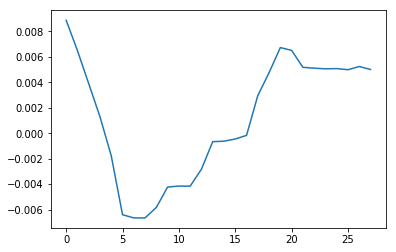

In [32]:
plt.plot(p_list[25:, 2])

In [ ]:
mmplan.planner.

In [14]:

# pick motion - move the object to "gripper"
from_state = initial_state.copy(pscene)
to_node = ("gripper", 0)
for _ in range(2):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    with gtimer.block("plan"):
        Traj, LastQ, error, success, binding_list = eplan.plan_transition(from_state, to_state, redundancy_dict, 
                                                                          N=5000, timeout=5, vel_conv=0, err_conv=1e-4)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    pick_state_etasl = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

Solution not found. Please try again, try to find error if it keeps failing.


RuntimeError: Motion plan failure

In [21]:
# place motion - move the object to "goal"
from_state = pick_state_etasl.copy(pscene)
to_node = ("goal", 0)
for _ in range(20):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    print("Sometimes this placement motion is inherently impossible depending on pick parameter.")
    print("Then, please re-try from the beginning to change the configuration")
    raise(RuntimeError("Motion plan failure"))

In [22]:
# sweep motion 1 - reach the first waypoint
from_state = place_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("goal", 1)
for _ in range(20):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

In [23]:
# sweep motion 2 - sweep "floor" to the second waypoint.
# Constrained motion is not implemented with eTaSL planner. So, it will not "sweep" the floor
from_state = sweep1_state.copy(pscene)
to_node = ("goal", 2)
for _ in range(10):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

In [24]:
# return: calling sample_leaf_state() with same binding state generates go-home motion target
from_state = sweep2_state.copy(pscene)
to_node = ("goal", 2)
for _ in range(10):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=1)
    if success:
        break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

============= try go home (indy0) ===================
===================== plan joint manipulation =====================


## 4.3 TaskPlanner

##### create PlanningPipeline

In [83]:
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)
ppline.set_motion_planner(MoveitPlanner(pscene))

In [84]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


##### RRT

In [26]:
from pkg.planning.task.rrt import TaskRRT
ppline.set_task_planner(TaskRRT(pscene))

- pick & place & sweep
  - single process

In [27]:
ppline.search(initial_state, goal_nodes=[("goal", 2)], verbose=True, 
              display=False, dt_vis=0.01, timeout_loop=100, multiprocess=False, timeout=1, timeout_constrained=10)
schedules = ppline.tplan.find_schedules()
schedules_sorted = ppline.tplan.sort_schedule(schedules)
ppline.play_schedule(ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0]), period=0.05)

try: 0 - ('floor', 0)->('gripper', 0)
try transition motion
transition motion tried: False
result: 0 - ('floor', 0)->('gripper', 0) = fail
try: 0 - ('floor', 0)->('gripper', 0)
try transition motion
transition motion tried: False
result: 0 - ('floor', 0)->('gripper', 0) = fail
try: 0 - ('floor', 0)->('floor', 1)
try transition motion
transition motion tried: True
result: 0 - ('floor', 0)->('floor', 1) = success
branching: 0->1 (2.07/100.0 s, steps/err: 11(22.5629806519 ms)/0.00176302312144)
try: 1 - ('floor', 1)->('floor', 2)
try constrained motion
constrained motion tried: True
result: 1 - ('floor', 1)->('floor', 2) = success
branching: 1->2 (2.1/100.0 s, steps/err: 39(21.4080810547 ms)/0.00182522927252)
try: 2 - ('floor', 2)->('gripper', 2)
try transition motion
transition motion tried: False
result: 2 - ('floor', 2)->('gripper', 2) = fail
try: 1 - ('floor', 1)->('floor', 2)
try constrained motion
constrained motion tried: True
result: 1 - ('floor', 1)->('floor', 2) = success
branchi

- pick & place & sweep  
  - multi process

In [28]:
ppline.search(initial_state, goal_nodes=[("goal", 2)], verbose=True, 
              display=False, dt_vis=0.01, timeout_loop=100, multiprocess=True, timeout=1, timeout_constrained=10)
schedules = ppline.tplan.find_schedules()
schedules_sorted = ppline.tplan.sort_schedule(schedules)
ppline.play_schedule(ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0]), period=0.05)

Use 20/20 agents
try: 0 - ('floor', 0)->('gripper', 0)
try transition motion
try: 0 - ('floor', 0)->('floor', 1)
try transition motion
try: 0 - ('floor', 0)->('floor', 1)
try transition motion
try: 0 - ('floor', 0)->('floor', 1)
try transition motion
try: 0 - ('floor', 0)->('floor', 1)
transition motion tried: True
try transition motion
result: 0 - ('floor', 0)->('floor', 1) = success
transition motion tried: True
transition motion tried: True
transition motion tried: True
result: 0 - ('floor', 0)->('floor', 1) = success
branching: 0->1 (0.06/100.0 s, steps/err: 12(20.2240943909 ms)/0.0020134982275)
try: 4 - ('floor', 1)->('floor', 2)
result: 0 - ('floor', 0)->('floor', 1) = success
branching: 0->2 (0.1/100.0 s, steps/err: 8(30.6451320648 ms)/0.00157191921104)
try constrained motion
result: 0 - ('floor', 0)->('floor', 1) = success
branching: 0->4 (0.13/100.0 s, steps/err: 6(57.4719905853 ms)/0.00170788310574)
branching: 0->3 (0.14/100.0 s, steps/err: 11(45.2270507812 ms)/0.001057526441

branching: 9->19 (0.55/100.0 s, steps/err: 78(172.652006149 ms)/0.00200317537977)
++ adding return motion to acquired answer ++
transition motion tried: True
transition motion tried: True
result: 0 - ('floor', 0)->('floor', 1) = success
=============== try reaching goal from ('gripper', 2) =================
transition motion tried: True
try: 19 - ('gripper', 2)->('goal', 2)
=============== try reaching goal from ('goal', 1) =================
try joint motion
result: 0 - ('floor', 0)->('floor', 1) = success
branching: 0->20 (0.59/100.0 s, steps/err: 8(198.384046555 ms)/0.000995934831667)
result: 15 - ('goal', 0)->('goal', 1) = success
transition motion tried: True
try transition motion
result: 11 - ('floor', 2)->('gripper', 2) = success
branching: 11->21 (0.64/100.0 s, steps/err: 8(101.831912994 ms)/0.00224370985791)
try: 21 - ('gripper', 2)->('goal', 2)
result: 17 - ('gripper', 2)->('goal', 2) = success
result: 6 - ('gripper', 0)->('gripper', 1) = success
joint motion tried: True
branc

result: 0 - ('floor', 0)->('gripper', 0) = fail
result: 6 - ('gripper', 0)->('floor', 0) = fail
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 7: first answer acquired from other agent ===============================
result: 6 - ('gripper', 0)->('floor', 0) = fail
======================= terminated 14: first answer acquired from other agent ===============================
transition motion tried: False
result: 6 - ('gripper', 0)->('floor', 0) = fail
======================= terminated 12: first answer acquired from other agent ===============================
transition motion tried: False
result: 6 - ('gripper', 0)->('floor', 0) = fail
======================= terminated 15: first answer acquired from other agent ===============================
transition motion tried: False
result: 6 - ('gripper', 0)->('floor', 0) = fail
======================= terminated 13: first answer acquired from othe

Process Process-12:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "pkg/planning/pipeline.py", line 177, in __search_loop
    self.add_return_motion(snode_new)
  File "pkg/planning/pipeline.py", line 226, in add_return_motion
    display=False, timeout=timeout)
  File "pkg/planning/pipeline.py", line 200, in test_connection
    self.mplan.plan_transition(from_state, to_state, redundancy_dict=redundancy_dict, **kwargs)
  File "pkg/planning/motion/interface.py", line 105, in plan_transition
    redundancy_values=redundancy_values, **kwargs)
  File "pkg/planning/motion/moveit/moveit_planner.py", line 166, in plan_algorithm
    group_name, tuple(to_Q), tuple(from_Q), timeout=timeout_joint)
  File "pkg/planning/motion/moveit/moveit_py.py", line 123, in plan_joint_motion_py
    JointSta